<a href="https://colab.research.google.com/github/KobeWang-supreme/Music-genre-classification-with-different-CNNs/blob/main/(Highest)_CNN_With_MelAndMfcc_5Genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are using the dataset called "GTZAN", which is widely used in Music Genre Classification.
Our goal is to use audios' mfccs to make the classification. This data_deal.ipynb will show how mfccs are generated.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import librosa
import os
import tqdm
import matplotlib.pyplot as plt
import random
import librosa.display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import classification_report
from sklearn import metrics

First we should read the data.

In [259]:
def data_read(directory="/content/drive/MyDrive/archive/Data/genres_original"): # change the directory if you like
    data = [] # Store all data (read from music)
    labels = [] # Store corresponding labels
    srs = []

    x = 0

    for dirname, _, filenames in os.walk("/content/drive/MyDrive/archive/Data/genres_original"):
        for filename in filenames:
            # Get name and skip the broken
            if x == 554:  # skip the broken one
                x += 1
                continue

            filename = os.path.join(dirname, filename)

            y, sr = librosa.load(filename)
            #print(filename)
            label = filename.split('/')[7]
            #print(label)

            if label == 'hiphop' or label == 'pop' or label == 'rock' or label == 'blues' or label == 'reggae':
              x += 1
              continue

            # Append them to the final data
            data.append(y)
            labels.append(label)
            srs.append(sr)
            x += 1
            #print(x)  # counting
    #print(len(data))

    return data, labels, srs

In [260]:
data, labels, srs = data_read()

Get one random sample to show whether we read the data successfully.

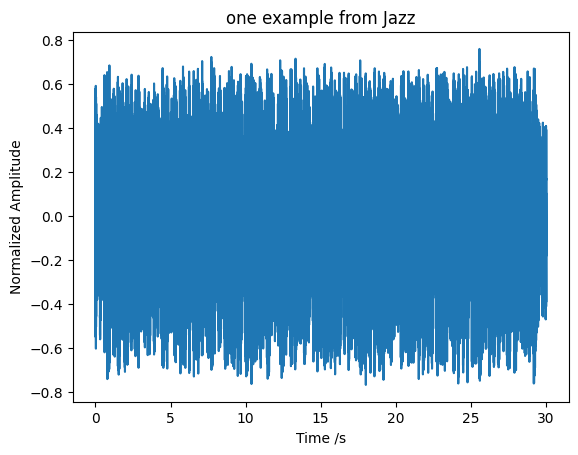

In [261]:
def check():
    fig, axi = plt.subplots(1,1) # initialize
    ind = random.randint(0, len(labels)-1) # randomly choose one index
    times = [sample/srs[ind] for sample in range(len(data[ind]))] # get time axis
    axi.plot(times, data[ind])
    axi.set_ylabel('Normalized Amplitude')
    axi.set_xlabel('Time /s')
    axi.set(title = "one example from " + labels[ind].capitalize())

    plt.show()

check()

Then we need to extract mfccs features from "data"

In [262]:
def get_mels(data, srs):
    '''
        input: data : array like data structure
               src : sampling rates
               num_mel: how many mel features you want

        return: mels
    '''
    mels = []
    for i in range(len(data)):
        mel = librosa.feature.melspectrogram(y=data[i], sr=srs[i], n_mels= 128, fmax=8000).T
        #print(np.shape(mel))
        mels.append(mel)


    return mels # contains every music's mel

In [263]:
mels = get_mels(data, srs)

In [264]:
def get_mfcc(data, srs, n_mfcc):
    '''Gets mfccs given a array like data structure and its sampling rates
    '''
    mfccs = []
    for i in range(len(data)):
        mfcc = librosa.feature.mfcc(y=data[i], sr=srs[i], n_mfcc=n_mfcc).T
        mfccs.append(mfcc)

    return mfccs

In [265]:
mfccs = get_mfcc(data, srs, n_mfcc=128)
max_length1 = len(max(mfccs, key=len))
def pad_mfcc(mfccs, max_length):
    'pads'
    mfccs_padded = []
    for mfcc in mfccs:
        mfcc_padded = np.pad(mfcc, pad_width=[(0,max_length-mfcc[:,0].shape[0]),(0,0)])
        mfccs_padded.append(mfcc_padded)
    return mfccs_padded


In [266]:
mfccs_padded = pad_mfcc(mfccs, max_length1)
print(np.shape(mfccs_padded[0]))

(1314, 128)


Then we need to pad mfccs to make them have the same length

In [267]:
max_length = len(max(mels, key=len)) # get the max length
def pad_mel(mels, max_length):
    'pads'
    mels_padded = []
    for mel in mels:
        mel_padded = np.pad(mel, pad_width=[(0,max_length-mel[:,0].shape[0]),(0,0)])
        mels_padded.append(mel_padded)
    return mels_padded

In [268]:
mels_padded = pad_mel(mels, max_length)

In [269]:
print(np.shape(mels_padded))


(499, 1314, 128)


In [270]:
mels_padded = np.add(mels_padded, mfccs_padded)
print(np.shape(mels_padded))


(499, 1314, 128)


Next, we put the mfccs_padded into dataloader

In [271]:
# convert data to numpy array
X = np.asarray(mels_padded)
# Mapping labels
codes = {
    #'blues':0,
    'classical':0,
    'country':1,  #
    'disco':2,
    #'hiphop':4,
    'jazz':3,
    'metal':4,
    #'pop':5,
    #'reggae':4
    #'rock':9  #
}

df_map = pd.DataFrame (labels, columns = ['labels'])
print(df_map)
df_map['labels'] = df_map['labels'].map(codes)
print(df_map)
y = df_map['labels'].to_numpy()
print(y)

      labels
0      metal
1      metal
2      metal
3      metal
4      metal
..       ...
494  country
495  country
496  country
497  country
498  country

[499 rows x 1 columns]
     labels
0         4
1         4
2         4
3         4
4         4
..      ...
494       1
495       1
496       1
497       1
498       1

[499 rows x 1 columns]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [272]:
print(X)

[[[-1.27294861e+02  4.39496651e+01  1.76518643e+00 ... -2.43103981e+00
   -2.38094524e-01  2.19939685e+00]
  [-1.06621010e+02  3.76000404e+01  3.94287491e+00 ... -2.61682892e+00
   -4.41287488e-01  1.30827320e+00]
  [-1.03032524e+02  3.31476936e+01  2.36790347e+00 ...  1.54346824e-01
   -8.05834234e-01  4.86966640e-01]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.40651474e+01  4.64830971e+01  1.02380095e+01 ...  2.90590465e-01
    2.23524332e+00  3.68576616e-01]
  [-2.36687183e+01  4.95052528e+01  8.84230709e+00 ...  1.58882618e-01
    1.18759692e+00  4.81371224e-01]
  [-4.03183556e+01  3.56275597e+01  5.28381586e-01 ... -1.08991928e-01
   -3.58874798e-02 -1.79958045e-01]
  ...
  [ 0.00000000e+00  0.0

In [273]:
# To split train_data, valid_data and test_data
def train_val_test_split(x, y, test_size, val_size, random_state=None, stratify=None):
    x_t, x_test, y_t, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=stratify)
    if stratify is not None:
        stratify = y_t
    x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=val_size, random_state=random_state, stratify=stratify)

    return x_train, y_train, x_val, y_val, x_test, y_test

def to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, test_batch=1,shuffle=True):

    train_dataset = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train).type(torch.LongTensor)) # create train_dataset
    val_dataset = TensorDataset(torch.Tensor(x_val),torch.Tensor(y_val).type(torch.LongTensor)) # create val_dataset
    test_dataset = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test).type(torch.LongTensor)) # create test_dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) # create your train_dataloader
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle) # create your val_dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=shuffle) # create your test_dataloader

    return train_dataloader, val_dataloader, test_dataloader

In [290]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(X, y, test_size=0.15, val_size=0.15, random_state=42, stratify=y)

train_dataloader, val_dataloader, test_dataloader = to_Dataloader(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, test_batch=1,shuffle=True)

print('finished')

finished


We then define a class called "early stop "
It is from : "https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py"

In [275]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

After doing all things above, it is time to build our model to train this dataset!

In [276]:
# Then we wanna define a resnet
class MelSpecClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1),
                   nn.PReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                   nn.BatchNorm2d(64)
                   )



        conv_layers += [self.b1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(64, 256, kernel_size=5, stride=2, padding=1)
        self.relu2 = nn.PReLU()
        self.bn2 = nn.BatchNorm2d(256)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.PReLU()
        self.bn3 = nn.BatchNorm2d(512)
        conv_layers += [self.conv3, self.relu3, self.bn3,]


        # 5th Convolution Block
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.PReLU()
        self.bn4 = nn.BatchNorm2d(256)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # 6th Convolution Block
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1)
        self.relu5 = nn.PReLU()
        self.bn5 = nn.BatchNorm2d(128)
        conv_layers += [self.conv5, self.relu5, self.bn5]


        # Dropout Layer
        self.drp = nn.Dropout2d(p = 0.4)

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=128, out_features=64)

        # Wrap the Convolutional Blocks
        self.fitter = nn.Sequential(*conv_layers, self.drp, self.ap, nn.Flatten(), self.fc, nn.Linear(in_features=64, out_features=5))

        self.initialize_weights()


    def forward(self, x):

        x = x.transpose(1,2)
        x.unsqueeze_(1)
        out = self.fitter(x)
        return out




    def initialize_weights(self) :
        for m in self.modules() :
            if isinstance(m, nn.Conv2d) :
                nn.init.kaiming_normal_(m.weight, a = 0.1)

                if m.bias is not None :
                    nn.init.constant_(m.bias, 0)


In [289]:
# check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Build functions which used for training and predicting

In [278]:
def training_loop(model, train_dataloader, optimizer, device=device):

    model.train() # Sets model to train mode
    batch_losses = []

    for x_batch, y_batch in train_dataloader:
        # Move batches to device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        yhat = model(x_batch)  #predictions on x

        # Forward pass
        loss = loss_function(yhat, y_batch)

        # Backward and optimize
        loss.backward()

        # Update parameters
        optimizer.step()

        batch_losses.append(loss.data.item())

    train_loss = np.mean(batch_losses)

    return train_loss  # Return train_loss and anything else you need

def validation_loop(model, val_dataloader, device=device):

    model.eval() # Sets model to val mode

    batch_losses = []

    for x_batch, y_batch in val_dataloader:

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        yhat = model(x_batch)  #predictions on x

        loss = loss_function(yhat, y_batch)

        batch_losses.append(loss.data.item())

    val_loss = np.mean(batch_losses)

    return val_loss

def train(model, train_dataloader, val_dataloader, optimizer, epochs, device="cuda", patience = None, temp=100):

    train_losses = []
    val_losses = []

    print(f"Initiating training.")

    # Check if early stop is enabled:
    if patience is not None:
        # Initialize EarlyStopping
        early_stopping = EarlyStopping(patience=patience, verbose=False, path='checkpoint.pt')

    for epoch in range(epochs):
        # Training loop

        train_loss = training_loop(model, train_dataloader, optimizer, device)
        train_losses.append(train_loss)

        # Validation loop
        with torch.no_grad():

            val_loss = validation_loop(model, val_dataloader, device)
            val_losses.append(val_loss)

        if patience != -1:
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("Early stop. Going back to the last checkpoint.")
                break

        if epoch % temp == 0:
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

    if patience != None and early_stopping.early_stop == True:
        print('Loading model from checkpoint...')
        model.load_state_dict(torch.load('checkpoint.pt'))
        print('Checkpoint loaded.')

    print("training finished.")

    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    # find position of lowest validation loss
    minposs = val_losses.index(min(val_losses)) + 1
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(val_losses + train_losses))  # consistent scale
    plt.xlim(0, len(train_losses) + 1)  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.title('Validation and Training Loss of CNN')
    plt.show()

    return model


def predict(model, test_loader, n_features, loss_function, device=device):
    # Make predictions using model
    preds = []
    true_values = []
    loss = 0
    model.eval()  # prep model for evaluation

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # move to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Make predictions
            pred = model(x_batch)

            preds.append(np.argmax(pred.cpu().numpy(), axis=1)[0])
            true_values.append(y_batch.cpu().numpy()[0])
            loss += loss_function(pred, y_batch)

        #Calculate Accuracy
        accuracy = sum(np.array(preds) == np.array(true_values))/len(true_values)

    return preds, true_values, accuracy

Initialize the model

In [291]:
model = MelSpecClassifier()
model.to(device)

MelSpecClassifier(
  (b1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv2d(64, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (relu2): PReLU(num_parameters=1)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): PReLU(num_parameters=1)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): PReLU(num_parameters=1)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), pad

In [292]:
learning_rate = 0.00011
weight_decay = 1e-4


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

Initiating training.
[0/1000] Training loss: 1.3802	 Validation loss: 1.2395.
[5/1000] Training loss: 0.6162	 Validation loss: 0.7167.
[10/1000] Training loss: 0.3247	 Validation loss: 0.4855.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
[15/1000] Training loss: 0.1749	 Validation loss: 0.4009.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
[20/1000] Training loss: 0.1058	 Validation loss: 0.3574.
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
EarlyStopping counter: 3 out of 15
[25/1000] Training loss: 0.0600	 Validation loss: 0.3328.
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 1 out of 15
EarlyStopping counter: 2 out of 15
[30/1000] Training loss: 0.0493	 Validation loss: 0.3214.
EarlyStopping counter: 3 out of 15
EarlyStopping counter: 4 out of 15
EarlyStopping counter: 5 out of 15
EarlyStopping counter: 6 out of 15
EarlyStopping counter: 7 out of 15
[35/1000] Train

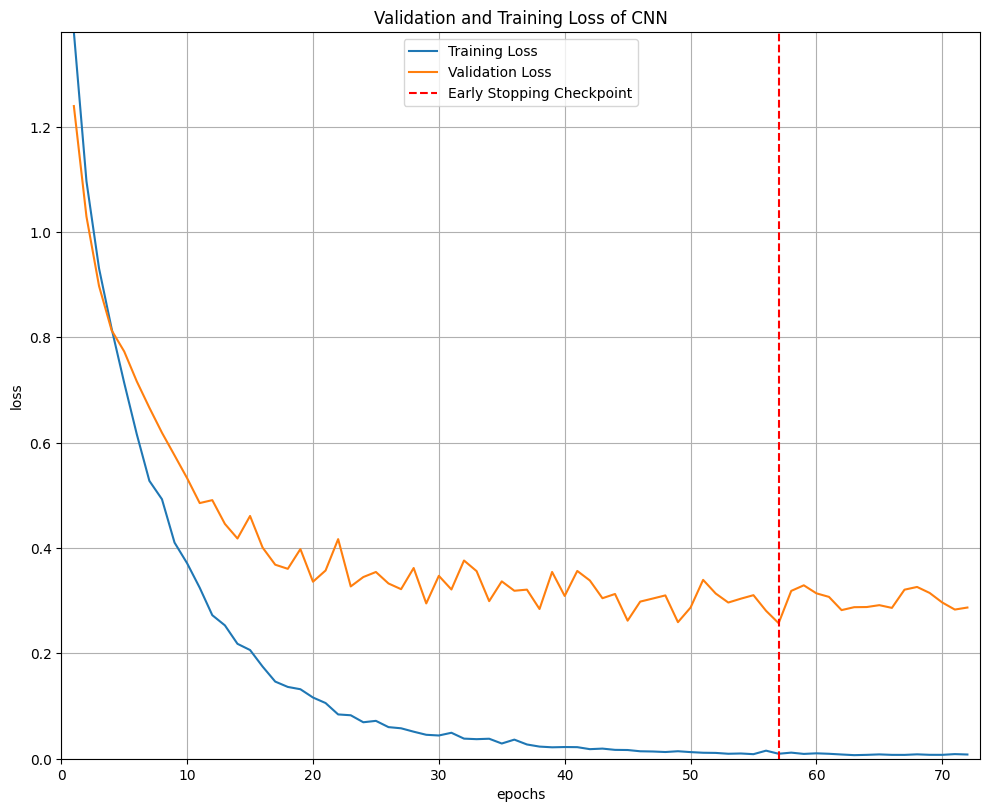

In [293]:
model = train(model, train_dataloader, val_dataloader, optimizer, epochs=1000, device="cuda", patience = 15, temp=5)

In [294]:
preds, true_values, accuracy = predict(model, test_dataloader, n_features=128, loss_function=loss_function, device=device)
print(classification_report(true_values, preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.73      0.85        15
           2       0.88      0.93      0.90        15
           3       0.82      0.93      0.87        15
           4       0.93      0.93      0.93        15

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



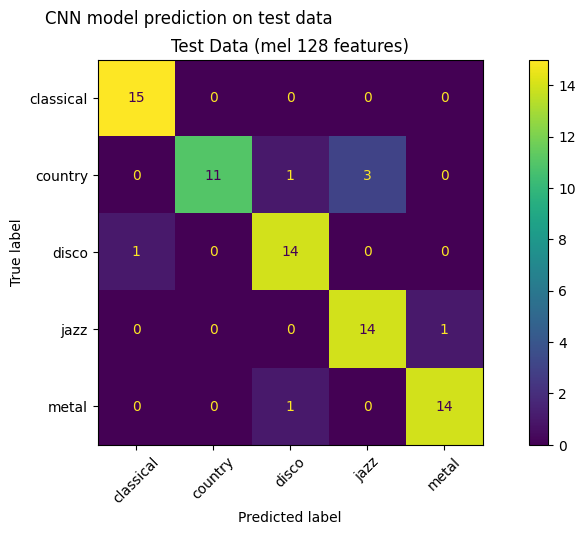

In [295]:
classlist = list(codes.keys())

# Plotting confusion matrices for small and big data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))  # Set up the figure


y_ = [true_values]
preds_lst = [preds]
titles = ['Test Data (mel 128 features)']
for i in range(1):
    actual = y_[i]
    predicted =preds_lst[i]  # get the prediction for each model (each loop)

    confusion_matrix = metrics.confusion_matrix(np.array(actual), np.array(predicted))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot(ax=ax)
    ax.set_xticklabels(classlist, rotation=45)
    ax.set_yticklabels(classlist)
    ax.set_title(titles[i])

fig.suptitle('CNN model prediction on test data')
plt.show()